In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-dark-palette')

In [3]:
train_raw_df = pd.read_csv("../../data/input/hugging_face/train_raw.csv")
train_raw_df = train_raw_df.sample(frac=1, random_state=322)

test_df = pd.read_csv("../../data/input/hugging_face/test.csv")
test_df = test_df.sample(frac=1, random_state=233)


In [4]:
print(train_raw_df.shape)

(105, 2)


In [5]:
batch_raw = pd.concat([train_raw_df,test_df],
axis=0,
ignore_index=True)
batch_raw.to_csv("../../data/input/hugging_face/data_val/raw_train_test.csv")



In [6]:
questions = batch_raw["Question"].to_list()

In [7]:
features_raw = model.encode(questions)

In [8]:
labels_raw = batch_raw["op_id"]

In [9]:
labels_raw.shape

(172,)

In [10]:
train_raw_shape = train_raw_df.shape
train_raw_features = features_raw[:train_raw_shape[0]]
test_raw_features = features_raw[train_raw_shape[0]:]
train_raw_labels = labels_raw[:train_raw_shape[0]]
test_raw_labels =labels_raw[train_raw_shape[0]:] 
np.savetxt("../../../../text-classification-small-datasets/datasets/train_feature_sbert.csv",train_raw_features,delimiter=",")
np.savetxt("../../../../text-classification-small-datasets/datasets/train_label_sbert.csv",train_raw_labels,delimiter=",")
np.savetxt("../../../../text-classification-small-datasets/datasets/test_feature_sbert.csv",test_raw_features,delimiter=",")
np.savetxt("../../../../text-classification-small-datasets/datasets/test_label_sbert.csv",test_raw_labels,delimiter=",")

In [11]:
print(train_raw_features.shape)
print(test_raw_features.shape)
print(train_raw_labels.shape)
print(test_raw_labels.shape)

(105, 768)
(67, 768)
(105,)
(67,)


In [12]:
train_raw_features.shape

(105, 768)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

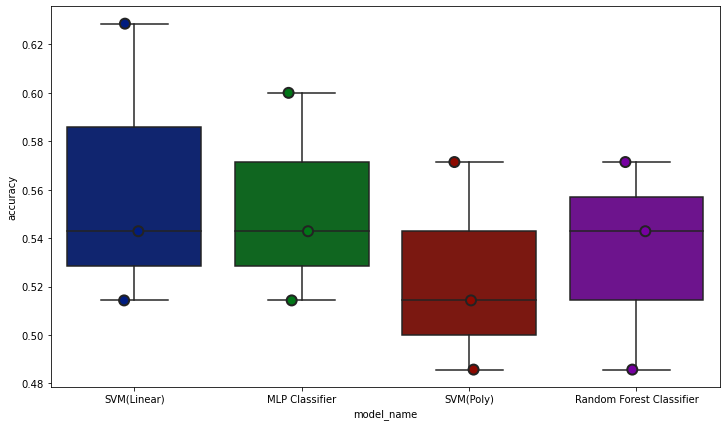

In [14]:

model_names = [
    "SVM(Linear)",
    "MLP Classifier",
    "SVM(Poly)",
    "Random Forest Classifier"
]
models = [
    SVC(kernel='linear',
        random_state=494,
    ),
    MLPClassifier( solver="adam", random_state=2343, hidden_layer_sizes=(),activation="relu"),
    SVC(kernel='poly',
        random_state=494,
    ),
    RandomForestClassifier(max_depth=10)
]

CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for i,model in enumerate(models):
    model_name = model_names[i]
    accuracies = cross_val_score(model,train_raw_features, train_raw_labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=[12,7])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig("../../figures/huggingface/test.png",bbox_inches='tight')
plt.show()

In [15]:
cv_df.groupby('model_name').accuracy.mean()

model_name
MLP Classifier              0.552381
Random Forest Classifier    0.533333
SVM(Linear)                 0.561905
SVM(Poly)                   0.523810
Name: accuracy, dtype: float64

Iteration 1, loss = 3.22530575
Iteration 2, loss = 3.01709709
Iteration 3, loss = 2.82386560
Iteration 4, loss = 2.64430396
Iteration 5, loss = 2.47729698
Iteration 6, loss = 2.32197562
Iteration 7, loss = 2.17769902
Iteration 8, loss = 2.04396771
Iteration 9, loss = 1.92026725
Iteration 10, loss = 1.80589544
Iteration 11, loss = 1.69986845
Iteration 12, loss = 1.60097851
Iteration 13, loss = 1.50799446
Iteration 14, loss = 1.41990514
Iteration 15, loss = 1.33608161
Iteration 16, loss = 1.25629280
Iteration 17, loss = 1.18060454
Iteration 18, loss = 1.10922094
Iteration 19, loss = 1.04233433
Iteration 20, loss = 0.98002543
Iteration 21, loss = 0.92222586
Iteration 22, loss = 0.86873226
Iteration 23, loss = 0.81924962
Iteration 24, loss = 0.77344238
Iteration 25, loss = 0.73097523
Iteration 26, loss = 0.69153672
Iteration 27, loss = 0.65484902
Iteration 28, loss = 0.62066637
Iteration 29, loss = 0.58877086
Iteration 30, loss = 0.55896614
Iteration 31, loss = 0.53107509
Iteration 32, los

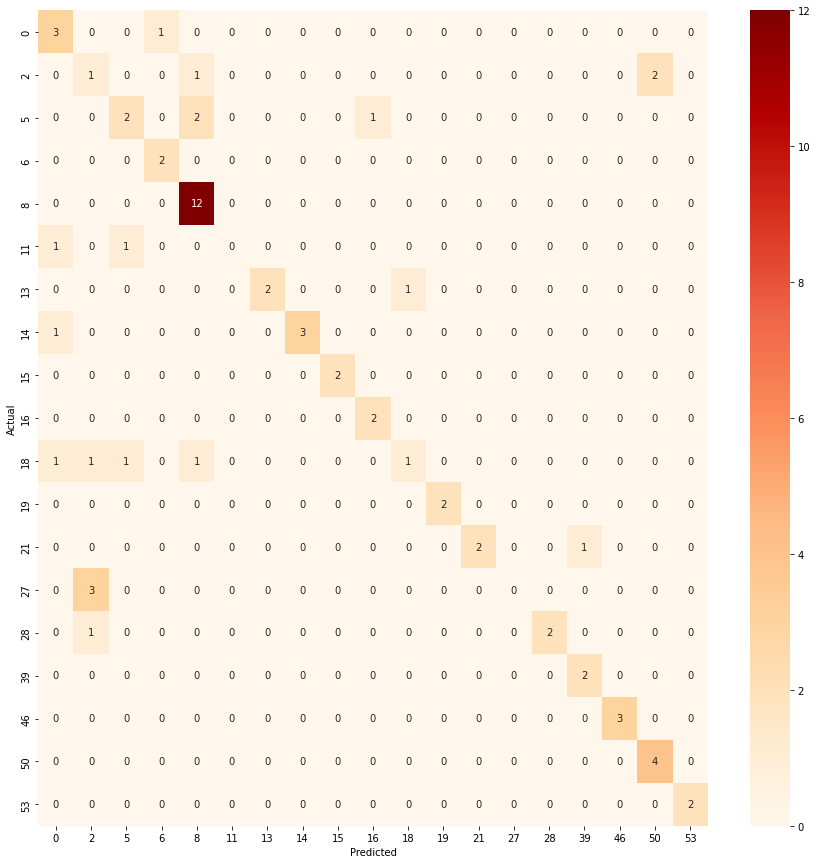

In [16]:
model =  MLPClassifier( solver="adam", random_state=2343, hidden_layer_sizes=(),activation="relu",
tol=1e-9,
verbose=True,
max_iter=30000,
momentum=1,
n_iter_no_change=1000
)

model.fit(train_raw_features, train_raw_labels)
y_pred = model.predict(test_raw_features)
print(y_pred)


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_raw_labels, y_pred)

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=sorted(list(set(test_raw_labels.values))), 
            yticklabels=sorted(list(set(test_raw_labels.values))),
            cmap='OrRd'
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [17]:
from sklearn import metrics
unique_keys = sorted(list(set(test_raw_labels.values)))
print('accuracy %s' %metrics.accuracy_score(y_pred,test_raw_labels))

accuracy 0.7014925373134329
